---
title: "SURVIVAL RATE ANALYSIS - UNSECURED PERSONAL LOAN PORTFOLIO"
---

## SURVIVAL RATE MODELING
### Analysis of Unsecured Personal Loan Portfolio Segemented by Credit Score, Rate and Original Loan Amount

This notebook demonstrates advanced survival analysis techniques using Kaplan-Meier and Cox regression models applied to unsecuredpersonal loan portfolio data. We progress from exploratory data analysis through univariate survival modeling to risk-adjusted survival estimates and competing risk analysis. Lastly, we'll compile findings for credit risk management and portfolio optimization applications.
Key Analyses:

1) Portfolio EDA and survival model readiness assessment

2) Kaplan-Meier survival estimation with censoring adjustments for young loans

3) Cox Proportional Hazards modeling with time-varying covariates

4) Credit risk management applications (PD modeling, portfolio segmentation, loss forecasting)

------------------------------------------------------------------------------------------------------

In [1]:
# Import Packages for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from scipy import stats
from lifelines import KaplanMeierFitter, NelsonAalenFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
## Front loading functions for later use

In [4]:
def bucket_loan_data(loan_data, col, bucket_col, bins, labels):
    """
    Bucket loan data into categories based on rate.
    """
    # Ensure 'rate' column exists
    if 'rate' not in loan_data.columns:
        raise ValueError("Data must contain 'rate' column for bucketing.")
    
    # Create buckets based on rate
    loan_data[bucket_col] = pd.cut(
                loan_data[col], 
                bins=bins, 
                labels=labels
    )
    return loan_data

In [5]:
def structure_loan_data(loan_data_csv):
    """
    Structure the raw loan data into a DataFrame with specific columns.
    """
    loan_data_raw = pd.read_csv(loan_data_csv)

    
    # Initialize dataframe for loan data
    loan_data = pd.DataFrame(columns=['loan_id', 'open_date', 'credit_score', '6_month_credit_score', 'rate', 'orig_amount', 'status', 'rate_bucket', 'score_bucket', 'orig_amount_bucket', 'open_year', 'open_month', 'open_month_str', 'maturity_date'])

    loan_data['loan_id'] = loan_data_raw.index + 1000
    loan_data['open_date'] = pd.to_datetime(loan_data_raw['OPEN_DATE'])
    loan_data['credit_score'] = loan_data_raw['CREDIT_SCORE_AT_ORIG']
    loan_data['6_month_score_change'] = loan_data_raw['6_MOS_SCORE_CHG']
    loan_data['rate'] = loan_data_raw['RATE']
    loan_data['orig_amount'] = loan_data_raw['LOAN_AMOUNT']
    loan_data['status'] = loan_data_raw['STATUS']

    # Randomly assign a amtuirty date between 3 and 8 years from the open date
    loan_data['maturity_date'] = loan_data['open_date'] + pd.to_timedelta(loan_data_raw['TERM'] * 30.44, unit='D')

    #Backfill other date columns
    loan_data['open_month'] = loan_data['open_date'].dt.to_period('M')
    loan_data['open_year'] = loan_data['open_date'].dt.year
    loan_data['open_month_str'] = loan_data['open_month'].astype(str)


    # Create buckets for rate
    rate_bucket_bins = [0, 5, 8, 12, 15, 22]
    rate_bucket_labels = ['Low', 'Low-Med', 'Medium', 'Med-High', 'High']
    loan_data = bucket_loan_data(loan_data, 'rate', 'rate_bucket',
                    bins=rate_bucket_bins,
                    labels=rate_bucket_labels
                    )

    # Create buckets for credit score
    score_bucket_bins=[-1, 629, 689, 749, 900]
    score_bucket_labels=['Subprime', 'Near-Prime', 'Prime', 'Super-Prime']
    loan_data = bucket_loan_data(loan_data, 'credit_score', 'score_bucket',
                    bins=score_bucket_bins,
                    labels=score_bucket_labels
                    )

    # Create buckets for orignal amount
    orig_amount_bucket_bins = [0, 5000, 10000, 20000, 30000, 50000]
    orig_amount_bucket_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    loan_data = bucket_loan_data(loan_data, 'orig_amount', 'orig_amount_bucket',
                    bins=orig_amount_bucket_bins,
                    labels=orig_amount_bucket_labels
                    )
    
    loan_data = loan_data[loan_data['rate'] > 0]
    #loan_data = loan_data[loan_data['credit_score'] > 0 ]
    return loan_data

In [6]:
def correlation_analysis(loan_data):
        """Analyze correlations between key variables"""
        # Select numeric columns for correlation
        numeric_cols = ['credit_score', 'rate', 'orig_amount', 'open_year']
        corr_matrix = loan_data[numeric_cols].corr()
        
        # Create correlation heatmap
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
                   square=True, ax=ax, cbar_kws={'label': 'Correlation Coefficient'})
        ax.set_title('Correlation Matrix - Key Loan Variables', fontweight='bold')
        
        return fig, corr_matrix

In [7]:
def default_rate_analysis(loan_data):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Credit Risk Analysis: Default Patterns', fontsize=16, fontweight='bold')

    # 1. Default Rate by Credit Score
    ax1 = axes[0,0]
    credit_default_rates = loan_data.groupby('score_bucket')['status'].apply(
        lambda x: (x == 'DEFAULT').mean() * 100
    )
    bars1 = ax1.bar(range(len(credit_default_rates)), credit_default_rates.values, 
                color='red', alpha=0.7, edgecolor='black')
    ax1.set_title('Default Rate by Credit Score', fontsize = 16, fontweight='bold')
    ax1.set_ylabel('Default Rate (%)', fontsize = 14, fontweight = 'bold')
    ax1.set_xticks(range(len(credit_default_rates)))
    ax1.set_xticklabels(credit_default_rates.index, rotation=45)

    # Add value labels
    for i, v in enumerate(credit_default_rates.values):
       ax1.text(i, v + 0.2, f'{v:.1f}%', ha='center', fontweight='bold')

    # 2. Default Rate by Interest Rate
    ax2 = axes[0,1] 
    rate_default_rates = loan_data.groupby('rate_bucket')['status'].apply(
       lambda x: (x == 'DEFAULT').mean() * 100
    )
    bars2 = ax2.bar(range(len(rate_default_rates)), rate_default_rates.values,
                color='orange', alpha=0.7, edgecolor='black')
    ax2.set_title('Default Rate by Interest Rate', fontsize = 16, fontweight='bold')
    ax2.set_ylabel('Default Rate (%)', )
    ax2.set_xticks(range(len(rate_default_rates)))
    ax2.set_xticklabels(rate_default_rates.index, rotation=45)

    # 3. Default Timing Distribution
    ax3 = axes[1,0]
    defaulted_loans = loan_data[loan_data['status'] == 'DEFAULT']
    ax3.hist(defaulted_loans['duration_months'], bins=15, alpha=0.7, 
         color='red', edgecolor='black')
    ax3.set_title('When Do Defaults Occur?', fontweight='bold')
    ax3.set_xlabel('Months to Default')
    ax3.set_ylabel('Number of Defaults')

    # 4. Default Rate by Vintage Year
    ax4 = axes[1,1]
    vintage_default_rates = loan_data.groupby('open_year')['status'].apply(
      lambda x: (x == 'DEFAULT').mean() * 100
    )
    ax4.bar(vintage_default_rates.index, vintage_default_rates.values)
    ax4.set_title('Default Rate by Origination Year', fontweight='bold')
    ax4.set_xlabel('Origination Year')
    ax4.set_ylabel('Default Rate (%)')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [8]:
def portfolio_summary_visual(loan_data):
    fig = plt.figure(figsize=(24, 9))

    # Plot 1: Status Distribution
    plt.subplot(1, 3, 1)
    status_counts = loan_data['status'].value_counts()
    bars1 = status_counts.plot(kind='bar', color='skyblue')
    plt.title('Loan Status Distribution', fontsize=16, fontweight='bold')
    plt.xlabel('Loan Status', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Loans', fontsize=14, fontweight='bold')
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add percentage labels on bars
    total_loans = status_counts.sum()
    for i, v in enumerate(status_counts.values):
        plt.text(i, v + 0.008*total_loans, f'{v:,}\n({v/total_loans*100:.1f}%)', 
                ha='center', va='bottom', fontsize=10)

    # Plot 2: Yearly Volume
    plt.subplot(1, 3, 2)
    yearly_volume = loan_data.groupby('open_year').size()
    years = yearly_volume.index.astype(str)  # Convert PeriodIndex to string for plotting
    plt.bar(years, yearly_volume.values, alpha=0.7, color='gold', edgecolor='black')
    plt.title('Loan Origination Volume by Year', fontsize=16, fontweight='bold')
    plt.xlabel('Origination Year', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Loans', fontsize=14, fontweight='bold')
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    year_loans = yearly_volume.sum()
    for i, v in enumerate(yearly_volume.values):
        plt.text(i, v + 0.001*year_loans, f'{v:,}\n({v/year_loans*100:.1f}%)', 
                ha='center', va='bottom', fontsize=10)


    # Plot 3: Status by Year
    # Fix for third plot - use ax parameter
    ax3 = plt.subplot(1, 3, 3)
    status_by_year = loan_data.groupby(['open_year', 'status']).size().unstack(fill_value=0)
    status_by_year.plot(kind='bar', stacked=True, alpha=0.8, 
                    color=['lightcoral', 'lightblue', 'lightgreen'], ax=ax3)
    plt.title('Portfolio Composition: Status by Origination Year', fontsize=16, fontweight='bold')
    plt.xlabel('Origination Year', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Loans', fontsize=14, fontweight='bold')
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [9]:
def prepare_survival_data(loan_data, observation_date=None):
    """
    Prepare loan data for survival analysis
    Focus: Time to Default (Approach 1)
    """
    
    # Set observation date if not provided
    if observation_date is None:
        observation_date = pd.Timestamp.now()
    else:
        observation_date = pd.to_datetime(observation_date, format='%m-%d-%Y')
    
    # Create a copy for survival analysis
    survival_data = loan_data.copy()
    
    # Define events: 1 = Default, 0 = Censored (Open or Closed)
    survival_data['event'] = (survival_data['status'] == 'DEFAULT').astype(int)
    
    # Calculate duration in months since origination
    survival_data['duration_months'] = (
        (observation_date - survival_data['open_date']).dt.days / 30.44
    ).round(2)
    
    # Basic validation
    print(f"  Observation Date: {observation_date.strftime('%Y-%m-%d')}")
    print(f"  Total Loans: {len(survival_data):,}")
    print(f"  Default Events: {survival_data['event'].sum():,} ({survival_data['event'].mean()*100:.1f}%)")
    print(f"  Censored Observations: {(1-survival_data['event']).sum():,} ({(1-survival_data['event']).mean()*100:.1f}%)")
    print(f"  Average Duration: {survival_data['duration_months'].mean():.1f} months")
    print(f"  Duration Range: {survival_data['duration_months'].min():.1f} to {survival_data['duration_months'].max():.1f} months")
    
    # Remove any negative durations (data quality issue)
    survival_data = survival_data[survival_data['duration_months'] >= 0]
    
    return survival_data

In [10]:
def survival_hazard_curve_visual(survival_data, kmf, naf):
    """
    Create comprehensive baseline survival visualization
    """
        
    plt.figure(figsize=(14, 8))
        
    # Plot 1: Main survival curve with confidence intervals
    plt.subplot(1,1,1)
    kmf.plot_survival_function(ci_alpha=0.3, color='blue', linewidth=3)
    plt.ylabel('Probability', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    # Add key survival milestones
    key_times = [12, 24, 36]
    for months in key_times:
        if months <= survival_data['duration_months'].max():
                survival_prob = kmf.survival_function_at_times(months).values[0]
                plt.plot(months, survival_prob, 'ro', markersize=6, color='black')
                plt.annotate(f'{months}m: {survival_prob:.1%}', 
                            xy=(months, survival_prob), 
                            xytext=(months-3, survival_prob - 0.1),
                            arrowprops=dict(arrowstyle='->', color='blue', alpha=0.7),
                            fontsize=10, ha='left')

    # Create second y-axis for cumulative hazard

    naf.plot_cumulative_hazard(color='red', linewidth=3, label='Cumulative Hazard')
    plt.tick_params(axis='y', labelcolor='red')
    plt.title('Portfolio Credit Risk: Survival vs. Cumulative Hazard', fontsize=16, fontweight='bold')
    plt.xlabel('Months Since Origination', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    # Add key survival milestones
    key_times = [12, 24, 36]
    for months in key_times:
        if months <= survival_data['duration_months'].max():
                survival_prob = naf.cumulative_hazard_at_times(months).values[0]
                plt.plot(months, survival_prob, 'ro', markersize=6, color='black')
                plt.annotate(f'{months}m: {survival_prob:.1%}', 
                            xy=(months, survival_prob), 
                            xytext=(months-3, survival_prob + 0.1),
                            arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                            fontsize=10, ha='left')
    plt.show()

In [11]:
def baseline_portfolio_summary(survival_data):
    # Portfolio risk metrics
    current_default_rate = survival_data['event'].mean()
    observation_period = survival_data['duration_months'].mean()
    
    print(f"Overall Default Rate: {current_default_rate:.1%}")
    print(f"Average Observation Period: {observation_period:.1f} months")
    
    # Annualized default rate estimation
    if observation_period > 0:
        annualized_default_rate = current_default_rate * (12 / observation_period)
        #stats['annualized_default_rate'] = annualized_default_rate
        print(f"Estimated Annualized Default Rate: {annualized_default_rate:.1%}")

In [12]:
def generate_survival_statistics(kmf, naf):
    """
    Generate key survival statistics and business metrics
    """
    
    # Key time points for business analysis
    time_points = [6, 12, 18, 24, 30, 36]
    for months in time_points:
        survival_prob = kmf.survival_function_at_times(months).values[0]
        default_prob = 1 - survival_prob
        cum_hazard = naf.cumulative_hazard_at_times(months).values[0]
        print(f"  {months:2d} months: {survival_prob:.1%} survival | {default_prob:.1%} default rate | Cumulative Hazard: {cum_hazard:.1%}")
            

In [13]:
def risk_segment_credit_analysis(survival_data):
    total_loans = pd.DataFrame(survival_data.groupby(['score_bucket']).count()['loan_id'])
    total_loans = total_loans['loan_id'].rename('Total Loans').reset_index()

    default_loans = pd.DataFrame(survival_data[survival_data['event'] == 1].groupby(['score_bucket']).count()['loan_id'])
    default_loans = default_loans['loan_id'].rename('Default Loans').reset_index()

    avg_duration = pd.DataFrame(survival_data.groupby('score_bucket')['duration_months'].mean())
    avg_duration = avg_duration['duration_months'].rename('Average Duration').reset_index()

    segmented_table = total_loans.join(default_loans, how='left', rsuffix='_default')
    segmented_table['Default Rate (%)'] = round(segmented_table['Default Loans'] / segmented_table['Total Loans'] * 100, 1)
    segmented_table = round(segmented_table.join(avg_duration, how='left', rsuffix='_total'), 2)

    segmented_table.rename(columns = {'score_bucket': 'Risk Segment'}, inplace=True)
    segmented_table.drop(columns =['score_bucket_default', 'score_bucket_total'], inplace=True)

    return segmented_table

In [14]:
def create_segmented_survival_analysis(survival_data, segments, segment_col, kmf_baseline):
    """
    Create survival analysis by credit score segments
    Focus on clean business insights
    """
    
    # Get unique segments in risk order (worst to best)
    #segments = ['Subprime', 'Near-Prime', 'Prime', 'Super-Prime']
    
    # Colors for business presentation (red to green, worst to best risk)
    colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']  # Red, Orange, Green, Blue
    
    # Storage for results
    segment_results = {}
    survival_summary = []
    
    # Create the main survival plot
    plt.figure(figsize=(14, 10))
    
    for i, segment in enumerate(segments):
        # Filter data for this segment
        segment_data = survival_data[survival_data[segment_col] == segment]

        # Calculate basic metrics
        total_loans = len(segment_data)
        defaults = segment_data['event'].sum()
        default_rate = (defaults / total_loans) * 100
        
        # Fit Kaplan-Meier for this segment
        kmf = KaplanMeierFitter()
        kmf.fit(
            durations=segment_data['duration_months'],
            event_observed=segment_data['event'],
            label=f'{segment} ({defaults} defaults | {round(default_rate, 1)}% default rate)'
        )
        
        # Plot survival curve
        kmf.plot_survival_function(
            color=colors[i], 
            linewidth=3,
            alpha=0.8,
            ci_alpha=0.1  # Light confidence interval
        )
        
        # Calculate key business metrics
        key_times = [6, 12, 18, 24, 30, 36]
        segment_metrics = {'segment': segment, 'total_loans': total_loans, 'defaults': defaults, 'default_rate': default_rate}
        
        for months in key_times:
            try:
                if months <= segment_data['duration_months'].max():
                    survival_prob = kmf.survival_function_at_times(months).values[0]
                    segment_metrics[f'survival_{months}m'] = survival_prob
                else:
                    segment_metrics[f'survival_{months}m'] = None
            except:
                segment_metrics[f'survival_{months}m'] = None
        
        survival_summary.append(segment_metrics)
        segment_results[segment] = {
            'kmf': kmf,
            'data': segment_data,
            'metrics': segment_metrics
        }
    
    # Format the plot
    kmf_baseline.plot_survival_function(ci_alpha = 0.0, color='black', linewidth=2, linestyle = '--')
    plt.title('Survival Analysis by Credit Risk Segment', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Months Since Origination', fontsize=14, fontweight='bold')
    plt.ylabel('Survival Probability (No Default)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower left', fontsize=12, framealpha=0.9)
    
    # Add key milestone annotations
    plt.axvline(x=12, color='gray', linestyle='--', alpha=0.5, label='12 Month Mark')
    plt.axvline(x=24, color='gray', linestyle='--', alpha=0.5, label='24 Month Mark')
    plt.axvline(x=36, color='gray', linestyle='--', alpha=0.5, label='36 Month Mark')
    
    # Set axis limits
    plt.xlim(0, max(survival_data['duration_months']) * 1.02)
    plt.ylim(-.02, 1.02)  # Focus on the range where action happens
    
    plt.tight_layout()
    plt.show()
    
    return segment_results, survival_summary

In [15]:
def create_survival_heatmap_data(survival_data, segments, segment_col):
    """
    Create heatmap showing survival rates by risk segment and time periods
    Perfect for identifying risk hotspots
    """
    
    # Define time periods and segments
    time_periods = [6, 12, 18, 24, 30, 36, 42]
    #segments = ['Subprime', 'Near-Prime', 'Prime', 'Super-Prime']
    
    # Initialize results matrices
    survival_matrix = []
    default_matrix = []
    sample_size_matrix = []
    
    # Calculate survival rates for each segment and time period
    for segment in segments:
        segment_data = survival_data[survival_data[segment_col] == segment]
            
        # Fit Kaplan-Meier for this segment
        kmf = KaplanMeierFitter()
        kmf.fit(segment_data['duration_months'], segment_data['event'])
        
        segment_survival = []
        segment_defaults = []
        segment_samples = []
        
        for months in time_periods:
            if months <= segment_data['duration_months'].max():
                # Get survival probability
                survival_rate = kmf.survival_function_at_times(months).values[0]
                default_rate = 1 - survival_rate
                    
                # Count loans at risk at this time point
                at_risk = (segment_data['duration_months'] >= months).sum()
                    
                segment_survival.append(survival_rate * 100)  # Convert to percentage
                segment_defaults.append(default_rate * 100)
                segment_samples.append(at_risk)
            else:
                # Insufficient data for this time period
                segment_survival.append(np.nan)
                segment_defaults.append(np.nan)
                segment_samples.append(0)
        
        survival_matrix.append(segment_survival)
        default_matrix.append(segment_defaults)
        sample_size_matrix.append(segment_samples)
    
    # Convert to DataFrames
    survival_df = pd.DataFrame(survival_matrix, 
                              index=segments, 
                              columns=[f'{m}m' for m in time_periods])
    
    default_df = pd.DataFrame(default_matrix, 
                             index=segments, 
                             columns=[f'{m}m' for m in time_periods])
    
    sample_df = pd.DataFrame(sample_size_matrix,
                            index=segments,
                            columns=[f'{m}m' for m in time_periods])
    
    return survival_df, default_df, sample_df

In [16]:
def plot_survival_heatmaps(survival_df, default_df, sample_df):
    """
    Create comprehensive heatmap visualizations
    """
    
    # Create figure with multiple heatmaps
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Credit Risk Heatmap Analysis: Survival Patterns by Segment and Time', 
                 fontsize=16, fontweight='bold')
    
    # 1. Survival Rate Heatmap
    ax1 = axes[0, 0]
    sns.heatmap(survival_df, annot=True, fmt='.1f', cmap='RdYlGn', 
                center=90, vmin=80, vmax=100, ax=ax1,
                cbar_kws={'label': 'Survival Rate (%)'})
    ax1.set_title('Survival Rates (%)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Time Period')
    ax1.set_ylabel('Credit Risk Segment')
    
    # 2. Default Rate Heatmap (inverted colors - red = bad)
    ax2 = axes[0, 1]
    sns.heatmap(default_df, annot=True, fmt='.1f', cmap='YlOrRd', 
                vmin=0, vmax=20, ax=ax2,
                cbar_kws={'label': 'Default Rate (%)'})
    ax2.set_title('Default Rates (%) - Risk Hotspots', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Time Period')
    ax2.set_ylabel('Credit Risk Segment')
    
    # 3. Sample Size Heatmap
    ax3 = axes[1, 0]
    sns.heatmap(sample_df, annot=True, fmt='d', cmap='Blues',
                ax=ax3, cbar_kws={'label': 'Loans at Risk'})
    ax3.set_title('Sample Sizes (Loans at Risk)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Time Period')
    ax3.set_ylabel('Credit Risk Segment')
    
    # 4. Risk Intensity Heatmap (Default Rate × Sample Size)
    ax4 = axes[1, 1]
    # Calculate risk intensity (default rate weighted by sample size)
    risk_intensity = default_df * (sample_df / sample_df.sum())
    sns.heatmap(risk_intensity, annot=True, fmt='.1f', cmap='Reds',
                ax=ax4, cbar_kws={'label': 'Risk Intensity Score'})
    ax4.set_title('Risk Intensity (Default Rate × Portfolio Weight)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Time Period')
    ax4.set_ylabel('Credit Risk Segment')
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [ ]:
def cox_regression_coefficients(cph):
    # Forest plot
    cph.plot()
    plt.title('Cox Regression Coefficients\n(Log Hazard Ratios)', fontsize=16, fontweight='bold')
    plt.xlabel('Hazard Ratio', fontsize=14, fontweight='bold')
    plt.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='No Effect (HR=1)')

    # Get current ytick positions and replace labels
    current_positions = plt.yticks()[0]  # Get the numeric positions
    new_labels = ['Super-Prime', 'Near-Prime','Prime', 'Orig Amt' , 'Rate']
    plt.yticks(current_positions, new_labels)
    
    plt.legend()
    plt.tight_layout()
    plt.show()

In [67]:
def cox_regression_summary(cph):
    hazard_ratios = np.exp(cph.summary['coef'])
    variables = cph.summary.index

    plt.figure(figsize=(10, 6))
    plt.barh(variables, hazard_ratios)
    plt.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='No Effect (HR=1)')
    plt.xlabel('Hazard Ratio')
    plt.title('Cox Regression - Hazard Ratios\n(Multiplicative Risk Factors)')

    # Get current ytick positions and replace labels
    current_positions = plt.yticks()[0]  # Get the numeric positions
    new_labels = ['Near-Prime', 'Prime', 'Super-Prime', 'Rate','Orig Amt']
    plt.yticks(current_positions, new_labels)
    
    plt.legend()
    plt.tight_layout()
    plt.show()

## 1.0 Loan Portfolio Sumamry and Exploratory Data Analysis
### 1.1 Generate Simulated Loan Portfolio

In [19]:
loan_data = structure_loan_data('loan_data.csv')

In [20]:
loan_data['score_bucket'].value_counts()

score_bucket
Prime          1560
Super-Prime    1407
Near-Prime     1204
Subprime        284
Name: count, dtype: int64

In [21]:
# start of Fed rate increase simulation
mid_date = datetime(2022, 4, 1)

In [22]:
loan_data['rate_status'] = loan_data['open_date'].apply(lambda x: 'Pre-Fed Rate Increase' if x < mid_date else 'Post-Fed Rate Increase')

In [23]:
loan_data['event_target'] = loan_data['status'].apply(lambda x: 1 if x == 'Defaulted' else 0)
loan_data['observation_date'] = max(loan_data['open_date'])

In [24]:
print("Loan data generated successfully.")

Loan data generated successfully.


In [25]:
print(f"Total Loans: {len(loan_data):,}")
print(f"Date Range: {loan_data['open_date'].min().strftime('%Y-%m-%d')} to {loan_data['open_date'].max().strftime('%Y-%m-%d')}")
print(f"Years Covered: {loan_data['open_year'].nunique()}")

Total Loans: 4,455
Date Range: 2021-02-01 to 2025-01-31
Years Covered: 5


#### Overview
This analysis utilizes a simulated personal loan portfolio designed to replicate realistic market conditions and lending patterns for survival analysis modeling. The dataset provides a robust foundation for examining loan performance, default behavior, and portfolio risk dynamics.

#### Loan Volume & Timing
- Total Loans Generated: 5,000
- Origination Period: January 1, 2019 – June 30, 2025
- Volume Distribution: Strategically weighted to reflect market conditions
- Higher origination volumes during low-rate environment (2019-2022)
- Reduced origination volumes post-rate increases (2022-2025)

#### Loan Terms & Structure
- Principal Amount Range: $1,000 – $50,000
- Maturity Terms: 3 to 8 years (variable by loan)
- Product Type: Unsecured personal loans with fixed rates and terms
- Amortization: Standard fixed-payment structure

#### Credit Risk Profile
- Credit Scores: Randomly distributed across realistic range (350-850)
- 6-Month Refresh Scores: Secondary credit score data point for risk monitoring
- Risk Segmentation: Natural distribution across credit quality spectrum

##### Rate Environment Stratification
The interest rate structure was strategically designed to mirror actual market conditions.

##### Pre-Rate Increase Period (2019 – April 2022):
- Lower base interest rates reflecting historical market conditions
- Higher loan origination volumes
- Inverse correlation maintained between credit scores and rates

##### Rate Increase Period (April 2022 – 2025):
- Progressive rate increases of 5-6 percentage points
- Gradual implementation over 18-24 months
- Corresponding reduction in loan origination volumes
- Maintained credit-risk pricing differentials

#### 1.2 Portfolio Summary and Review

In [26]:
print("\033[1mPortfolio summary statistics results are the following:\033[0m")
print(f"  Total Number of Loans: {len(loan_data):,}")
print(f"  Average Portfolio Rate: {loan_data['rate'].mean():.2f}%")
print(f"  Average Original Amount: ${int(loan_data['orig_amount'].mean()):,}")
print(f"  Average Credit Score: {int(loan_data['credit_score'].mean())}")

Portfolio summary statistics results are the following:
  Total Number of Loans: 4,455
  Average Portfolio Rate: 12.33%
  Average Original Amount: $13,905
  Average Credit Score: 710


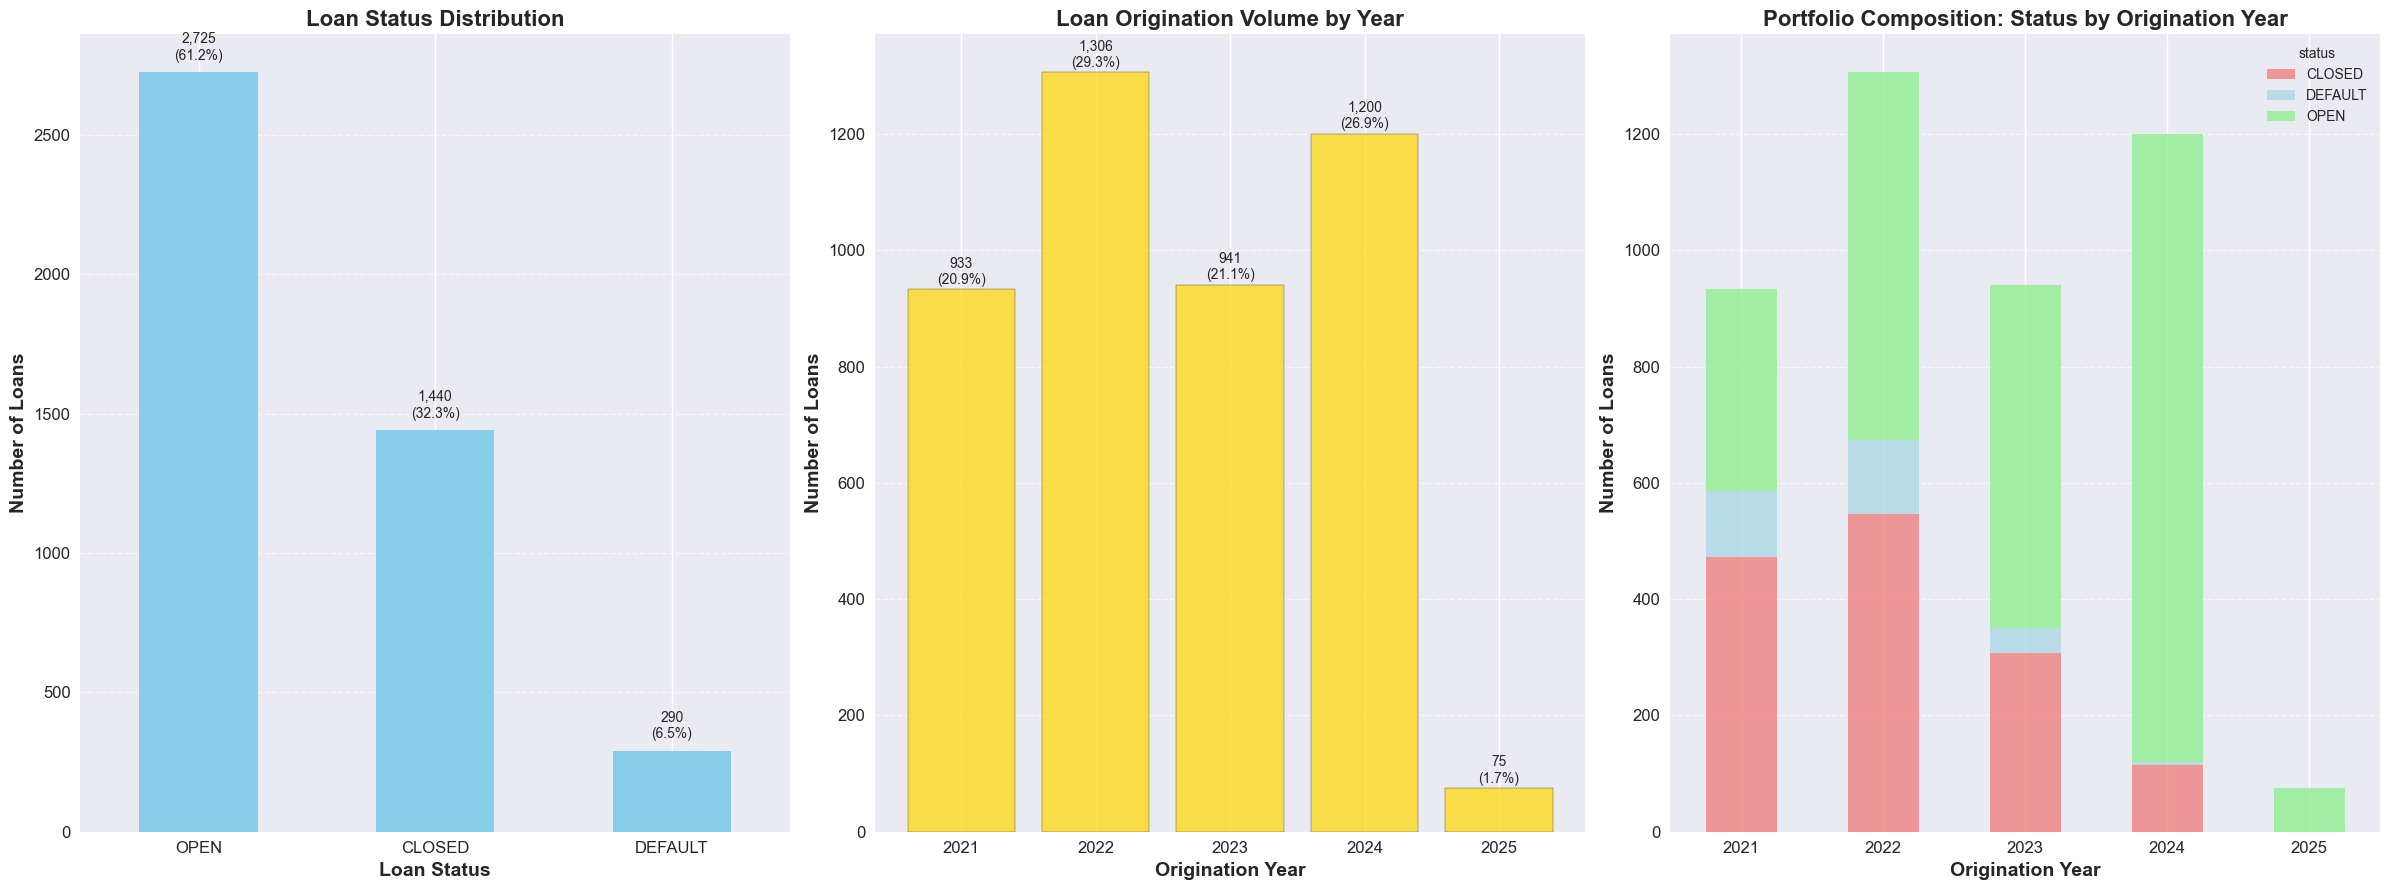

In [27]:
portfolio_summary_visual = portfolio_summary_visual(loan_data)

Maybe add % open, closed, default, total by year as a table

#### 1.3 Key Metrics Summary by Credit Score, Rate, and Opening Amount

In [28]:
loan_data['duration_months'] = (
        (loan_data['observation_date'] - loan_data['open_date']).dt.days / 30.44
    ).round(2)

In [29]:
print("\033[1mDEFAULT RATES BY ORIGINATION VINTAGE:\033[0m")

DEFAULT RATES BY ORIGINATION VINTAGE:


In [30]:
# Create the grouped data
vintage_defaults = loan_data.groupby('open_year').agg({
    'status': [
        'count',
        lambda x: (x == 'DEFAULT').sum(),
        lambda x: (x == 'DEFAULT').mean() * 100
    ],
    'duration_months': 'mean'
}).round(1)

# Flatten column names and rename
vintage_defaults.columns = ['Total_Loans', 'Defaults', 'Default_Rate_Pct', 'Avg_Duration_Months']

# Reset index to make open_year a column
vintage_defaults = vintage_defaults.reset_index()

print(vintage_defaults.to_string(index=False))

 open_year  Total_Loans  Defaults  Default_Rate_Pct  Avg_Duration_Months
      2021          933       114              12.2                 43.3
      2022         1306       127               9.7                 31.3
      2023          941        44               4.7                 18.8
      2024         1200         5               0.4                  7.3
      2025           75         0               0.0                  0.5


In [31]:
print("\033[1mDEFAULT RISK ANALYSIS BY KEY SEGMENTS:\033[0m")

DEFAULT RISK ANALYSIS BY KEY SEGMENTS:


In [32]:

# Credit Score Default Rates
print("\n1. Default Rates by Credit Score Segment:")
credit_defaults = loan_data.groupby('score_bucket').agg({
    'status': [
        'count',
        lambda x: (x == 'DEFAULT').sum(),
        lambda x: (x == 'DEFAULT').mean() * 100
    ]
}).round(1)
credit_defaults.columns = ['Total_Loans', 'Defaults', 'Default_Rate_%']
print(credit_defaults)

# Rate Bucket Default Rates  
print("\n2. Default Rates by Interest Rate Segment:")
rate_defaults = loan_data.groupby('rate_bucket').agg({
    'status': [
        'count', 
        lambda x: (x == 'DEFAULT').sum(),
        lambda x: (x == 'DEFAULT').mean() * 100
    ]
}).round(1)
rate_defaults.columns = ['Total_Loans', 'Defaults', 'Default_Rate_%']
print(rate_defaults)

# Risk Differentiation Summary
print(f"\n3. Risk Differentiation:")
highest_risk = credit_defaults['Default_Rate_%'].max()
lowest_risk = credit_defaults['Default_Rate_%'].min()
print(f"   • Credit Score Risk Spread: {highest_risk - lowest_risk:.1f} percentage points")
print(f"   • Highest Risk Segment: {highest_risk:.1f}% default rate")
print(f"   • Lowest Risk Segment: {lowest_risk:.1f}% default rate")


1. Default Rates by Credit Score Segment:
              Total_Loans  Defaults  Default_Rate_%
score_bucket                                       
Subprime              284        41            14.4
Near-Prime           1204       135            11.2
Prime                1560        90             5.8
Super-Prime          1407        24             1.7

2. Default Rates by Interest Rate Segment:
             Total_Loans  Defaults  Default_Rate_%
rate_bucket                                       
Low                    0         0             NaN
Low-Med                1         0             0.0
Medium              2351       156             6.6
Med-High            1610        93             5.8
High                 489        40             8.2

3. Risk Differentiation:
   • Credit Score Risk Spread: 12.7 percentage points
   • Highest Risk Segment: 14.4% default rate
   • Lowest Risk Segment: 1.7% default rate


Add some commentary here

In [33]:
print("\033[1mVISUALIZE DEFAULT RISK SEGMENTS:\033[0m")

VISUALIZE DEFAULT RISK SEGMENTS:


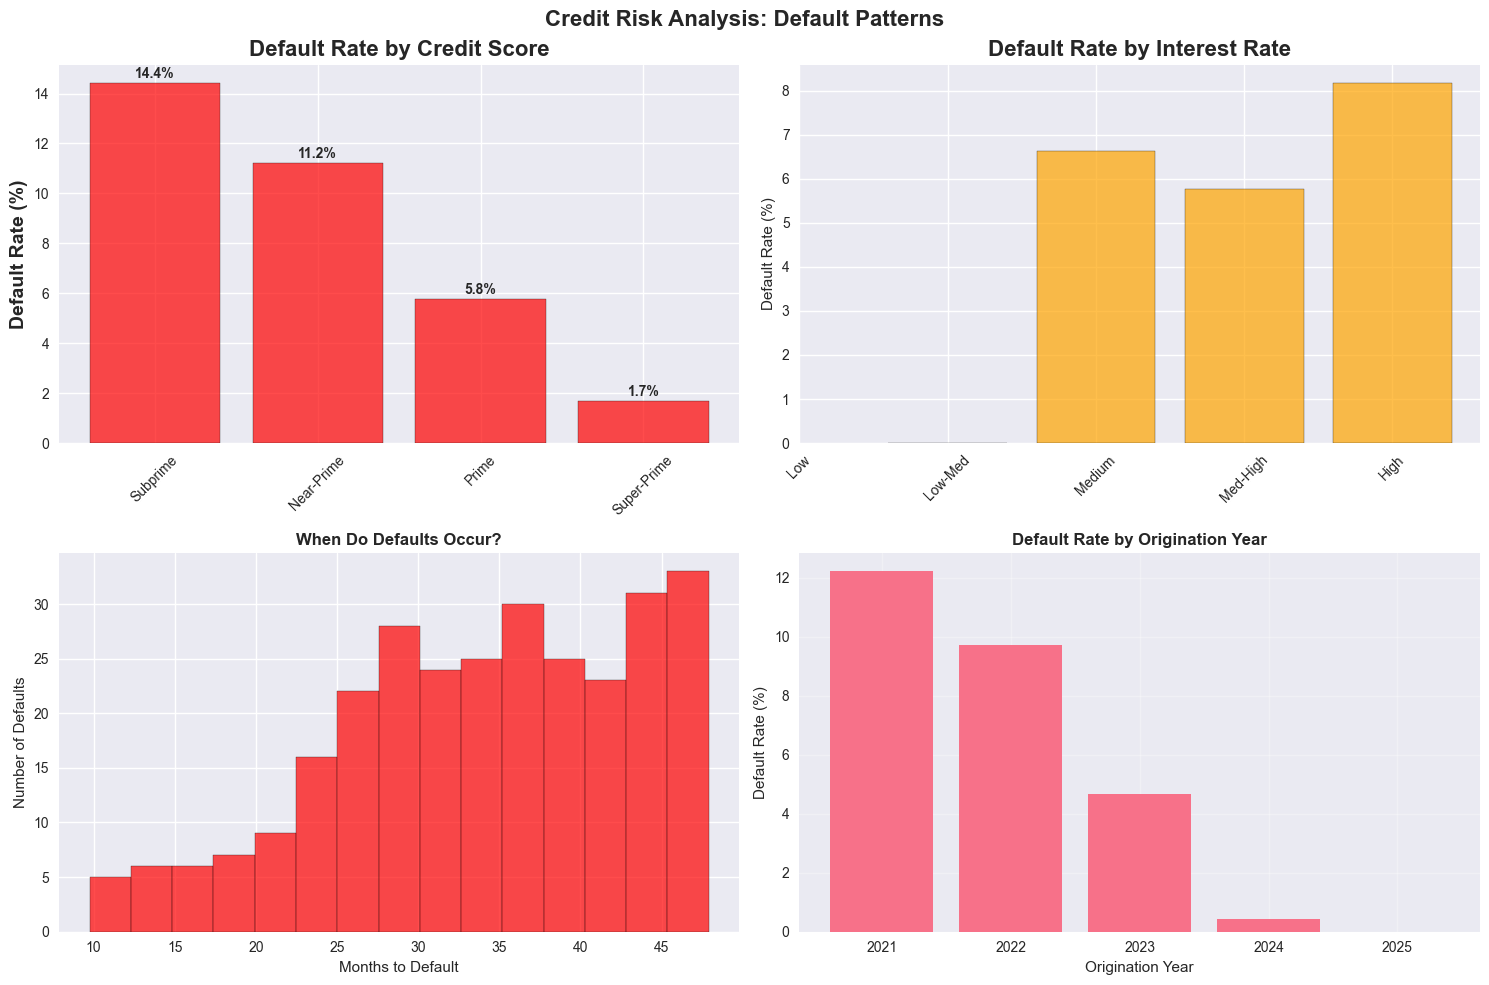

In [34]:
default_rate_analysis(loan_data)

Write a detailed summary about what I'm seeing in the data. May need to add another section on the Rate analysis

## 2.0 Kaplan-Meier Survival Rate Analysis

Add a brief writeup of the appraoch. Focus on defaulted. Binary targets: 1 = defaulted, 0 = closed or open. using months as the unit of measurement.

#### 2.1 Baseline Kaplan-Meier Survival Rate and Cumulative Hazard Analysis

In [35]:
print("\033[1mBASELINE SURVIVAL ANALYSIS - DATA PREPARATION:\033[0m")

BASELINE SURVIVAL ANALYSIS - DATA PREPARATION:


In [36]:
survival_data = prepare_survival_data(loan_data, '01-31-2025')

  Observation Date: 2025-01-31
  Total Loans: 4,455
  Default Events: 290 (6.5%)
  Censored Observations: 4,165 (93.5%)
  Average Duration: 24.2 months
  Duration Range: 0.0 to 48.0 months


#### 2.2 Fit and Visualize the Baseline Model

In [37]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Initialize Kaplan-Meier Fitter
    kmf = KaplanMeierFitter()
        
    # Fit the survival curve
    kmf.fit(survival_data['duration_months'], 
                survival_data['event'],
                label='Portfolio Baseline Survival Rate')

    # Initialize Nelson Aalen Fitter
    naf = NelsonAalenFitter()

    # Fit hazard curve
    naf.fit(survival_data['duration_months'], 
            survival_data['event'],
            label= 'Portfolio Baseline Hazard Rate')

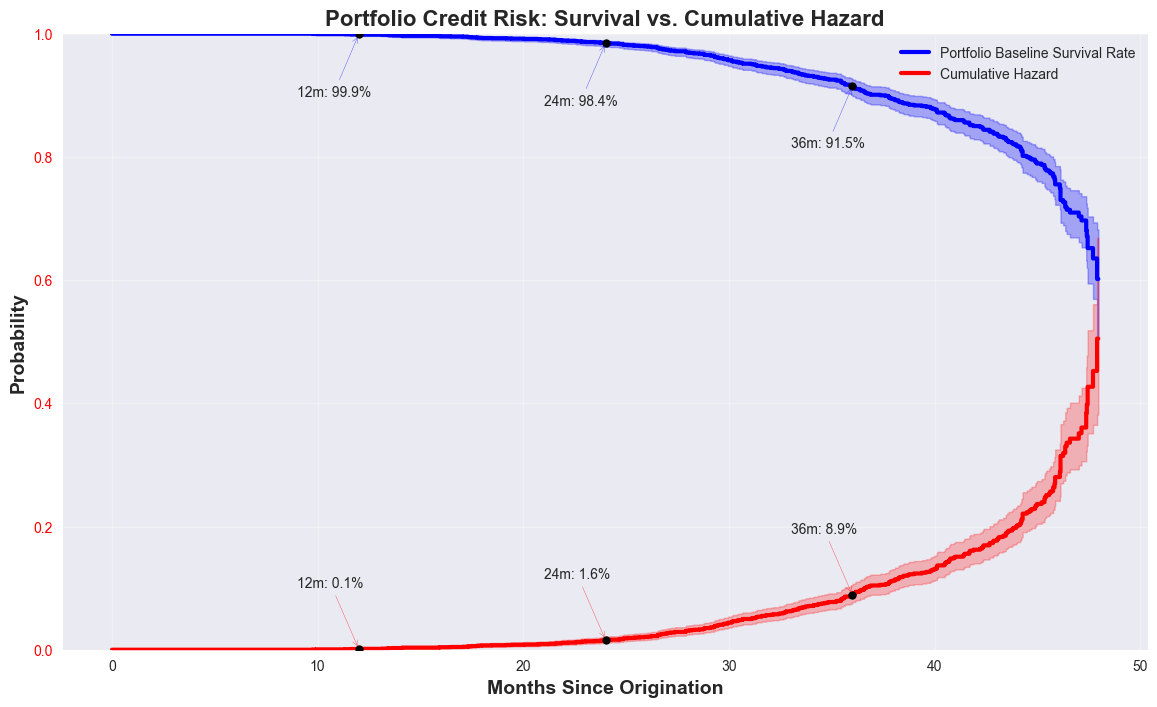

In [38]:
survival_hazard_curve_visual = survival_hazard_curve_visual(survival_data, kmf, naf)

Provide a summary

#### 2.3 Evaluate Summary Statistics of Baseline Model

In [39]:
print("\033[1mPORTFOLIO RISK METRICS:\033[0m")

PORTFOLIO RISK METRICS:


In [40]:
baseline_portfolio_summary(survival_data)

Overall Default Rate: 6.5%
Average Observation Period: 24.2 months
Estimated Annualized Default Rate: 3.2%


In [41]:
print("\033[1mBASELINE SURVIVAL STATISTICS:\033[0m")

BASELINE SURVIVAL STATISTICS:


In [42]:
generate_survival_statistics(kmf, naf)

# For loans that DO default, what's the median time?
defaulted_loans = survival_data[survival_data['event'] == 1]
median_time_to_default = defaulted_loans['duration_months'].median()
print(f"\n  Median time to default (for loans that default): {median_time_to_default:.1f} months")
mean_time_to_default = defaulted_loans['duration_months'].mean()
print(f"\n  Average time to default (for loans that default): {mean_time_to_default:.1f} months")

   6 months: 100.0% survival | 0.0% default rate | Cumulative Hazard: 0.0%
  12 months: 99.9% survival | 0.1% default rate | Cumulative Hazard: 0.1%
  18 months: 99.3% survival | 0.7% default rate | Cumulative Hazard: 0.7%
  24 months: 98.4% survival | 1.6% default rate | Cumulative Hazard: 1.6%
  30 months: 95.7% survival | 4.3% default rate | Cumulative Hazard: 4.4%
  36 months: 91.5% survival | 8.5% default rate | Cumulative Hazard: 8.9%

  Median time to default (for loans that default): 34.6 months

  Average time to default (for loans that default): 33.9 months


#### 2.4 Fit and Visualize Models with Risk Segmentation

In [43]:
print("\033[1mSEGMENTED CREDIT ANALYSIS:\033[0m")

SEGMENTED CREDIT ANALYSIS:


In [44]:
segmented_table = risk_segment_credit_analysis(survival_data)
print(segmented_table)

  Risk Segment  Total Loans  Default Loans  Default Rate (%)  Average Duration
0     Subprime          284             41              14.4             24.18
1   Near-Prime         1204            135              11.2             24.97
2        Prime         1560             90               5.8             24.30
3  Super-Prime         1407             24               1.7             23.47


In [45]:
print("\033[1mSEGMENTED SURVIVAL RATES:\033[0m")

SEGMENTED SURVIVAL RATES:


In [46]:
segments = ['Subprime', 'Near-Prime', 'Prime', 'Super-Prime']
segment_col = 'score_bucket'

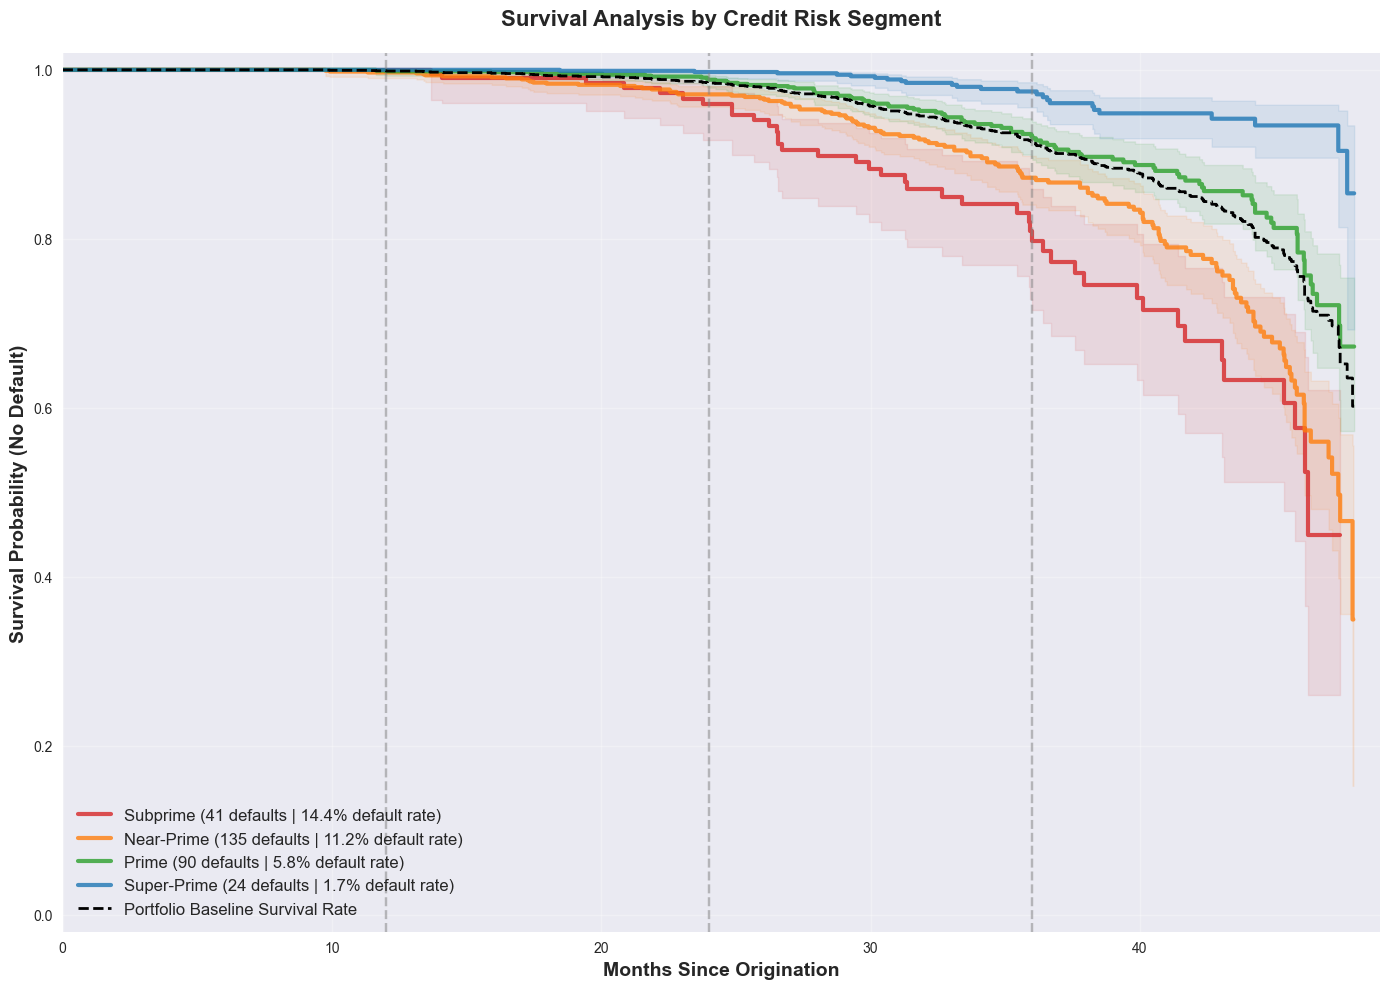

In [47]:
segmented_survival_analysis = create_segmented_survival_analysis(survival_data, segments, segment_col, kmf)

Commentary

In [48]:
print("\033[1mCREDIT RISK HEATMAP ANALYSIS:\033[0m")

CREDIT RISK HEATMAP ANALYSIS:


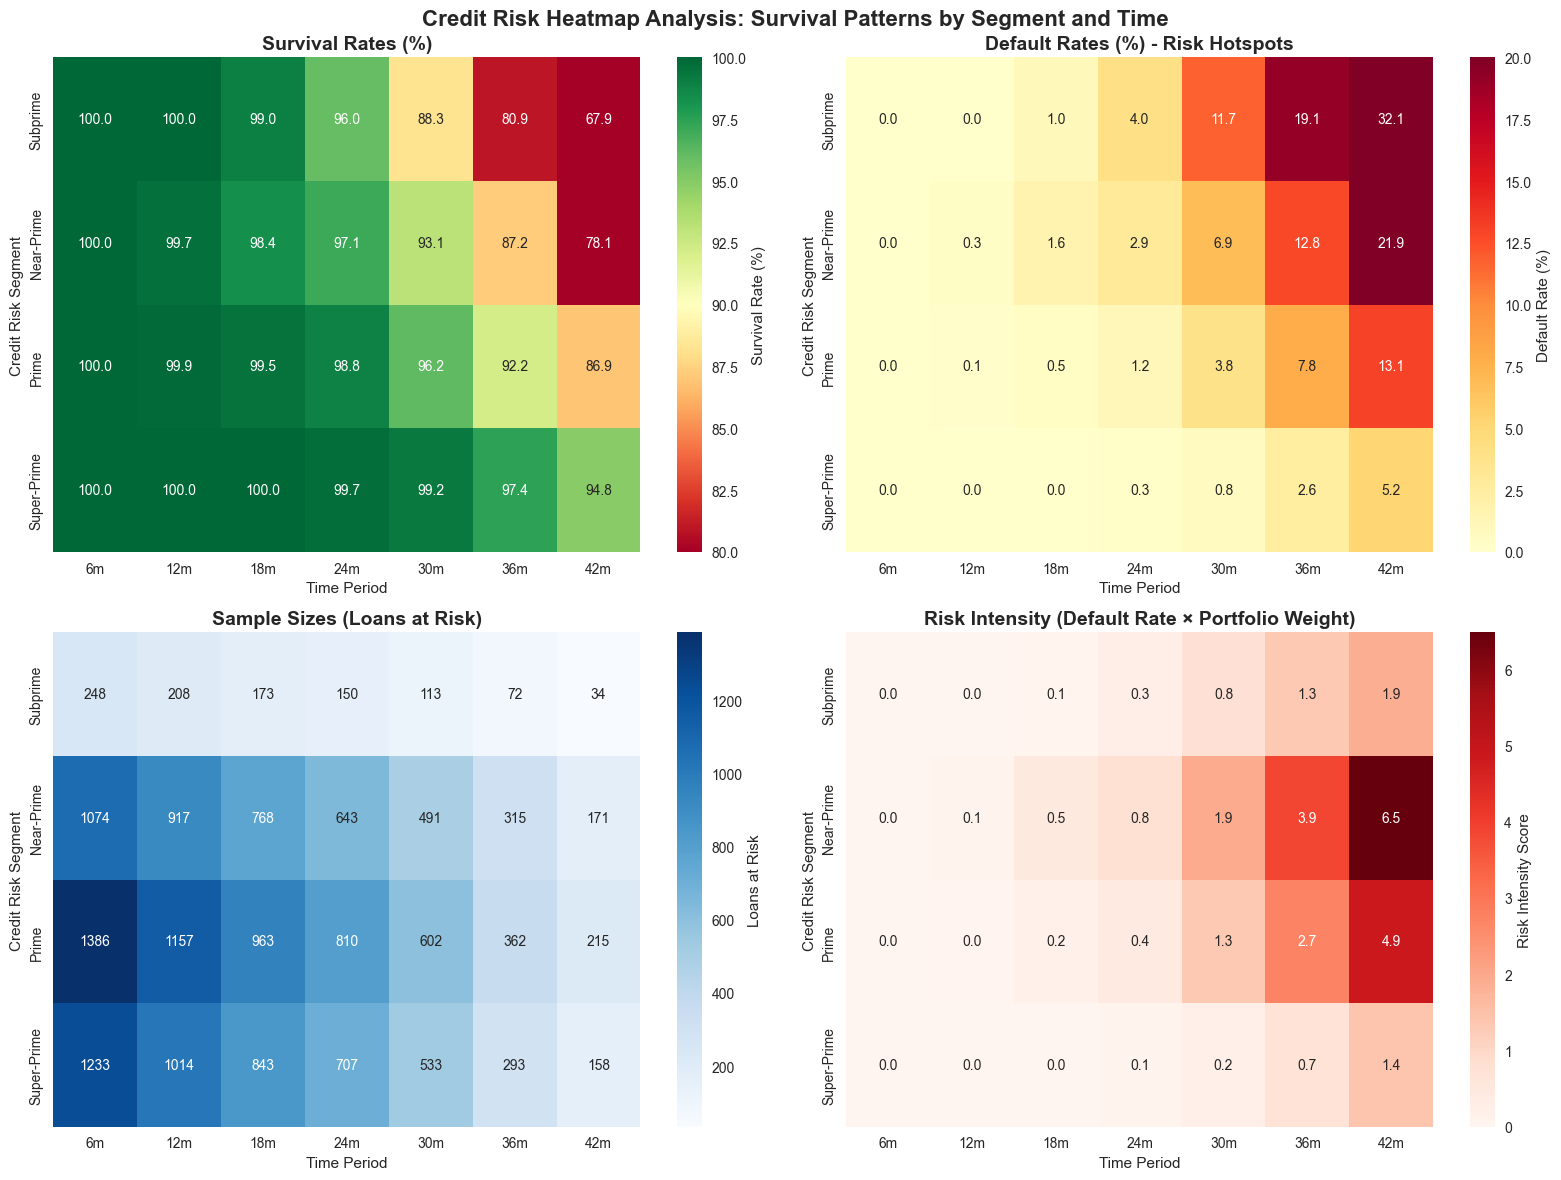

In [49]:
survival_df, default_df, sample_df = create_survival_heatmap_data(survival_data, segments, segment_col)
survival_heatmaps = plot_survival_heatmaps(survival_df, default_df, sample_df)

Commentary

#### 2.5 Fit and Visualize Model with Interest Rate Period Segmentation

In [50]:
segments = survival_data['rate_status'].unique()
segment_col = 'rate_status'

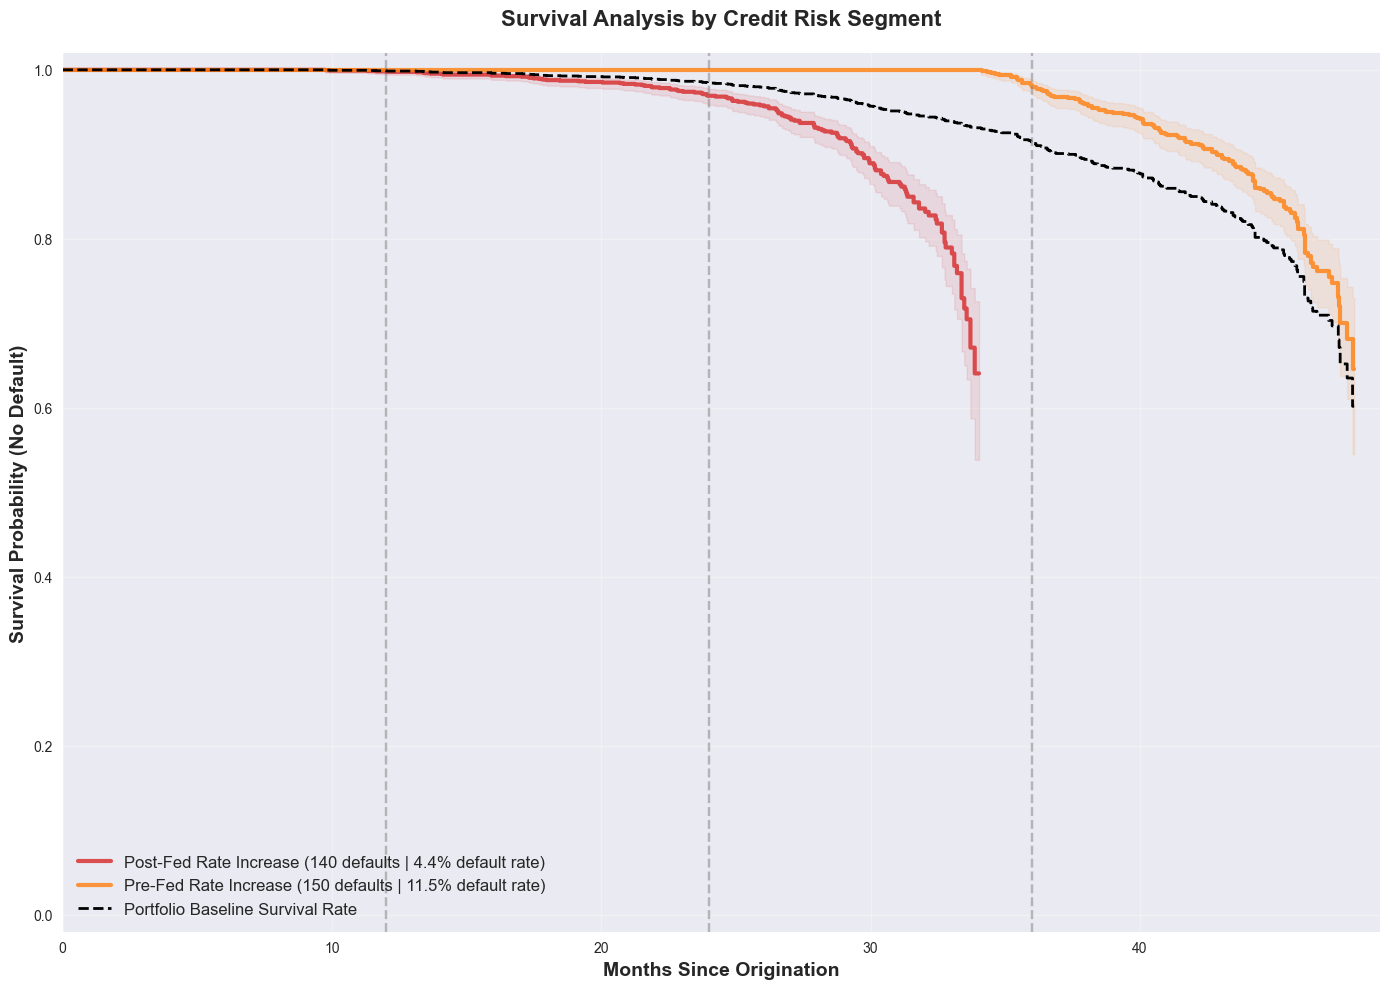

In [51]:
segmented_survival_analysis = create_segmented_survival_analysis(survival_data, segments, segment_col, kmf)

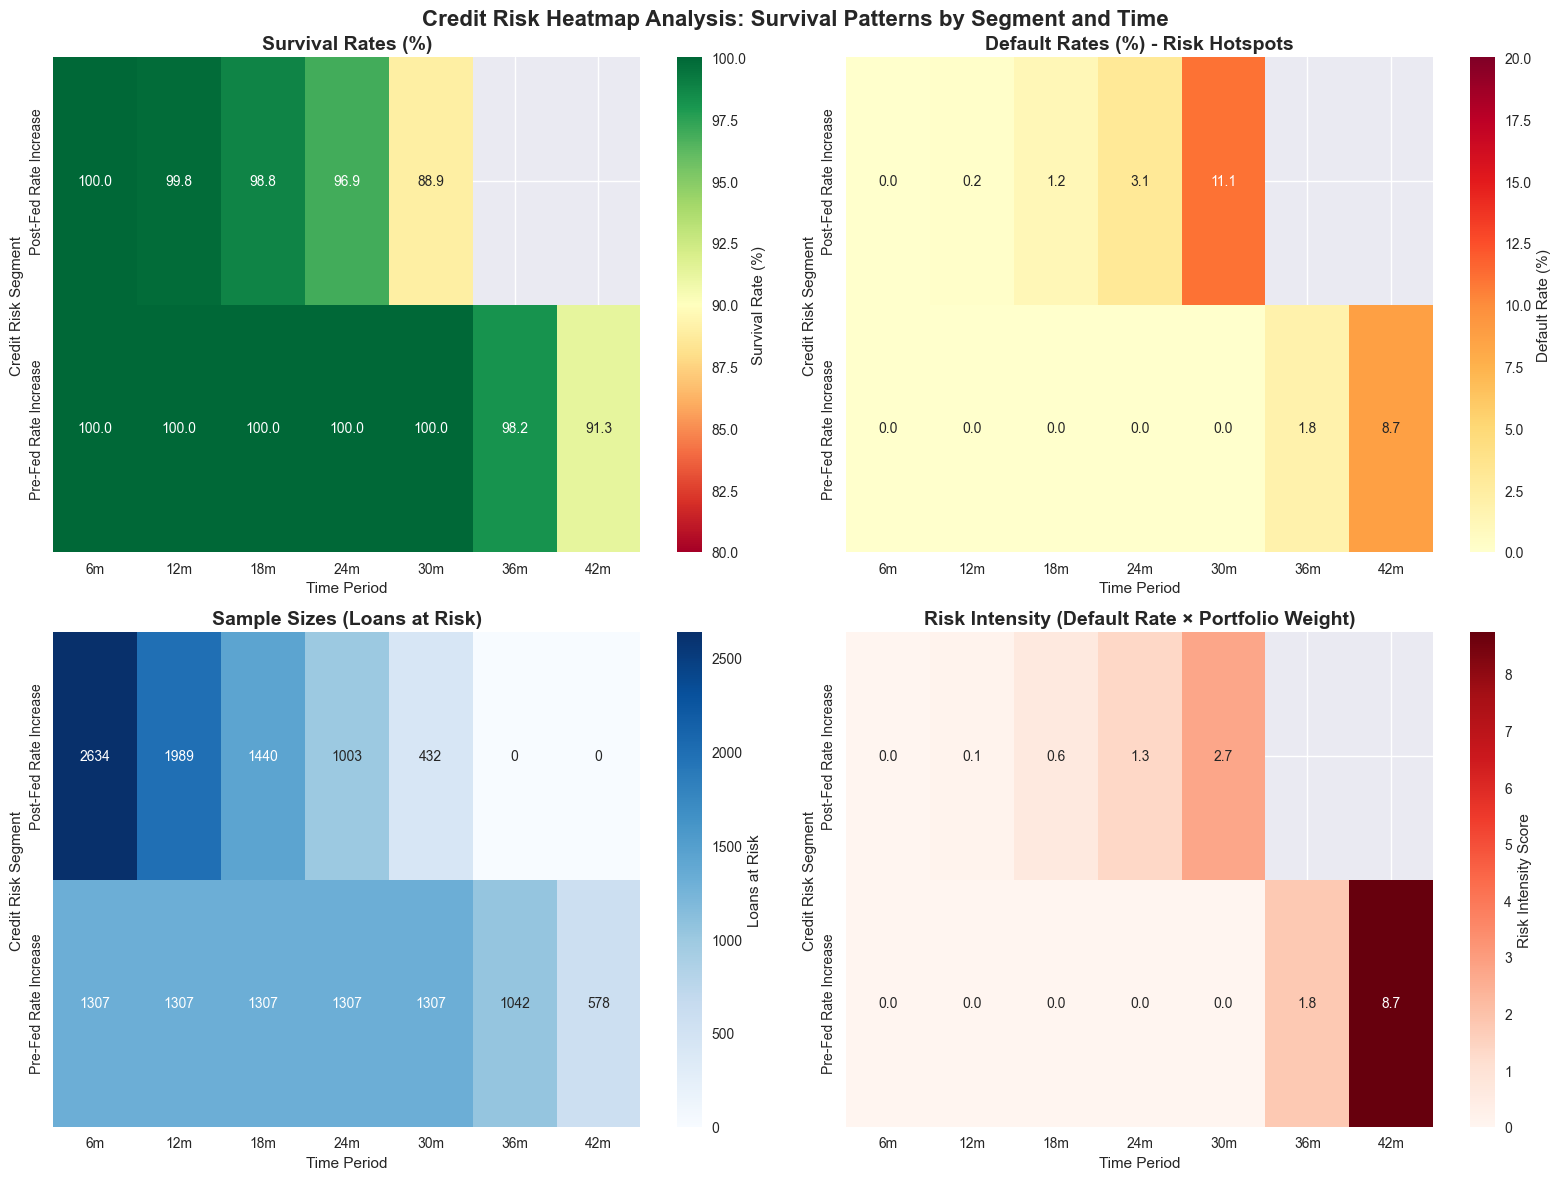

In [52]:
survival_df, default_df, sample_df = create_survival_heatmap_data(survival_data, segments, segment_col)
survival_heatmaps = plot_survival_heatmaps(survival_df, default_df, sample_df)

#### 2.6 Fit and Visualize with Risk and Interest Rate Period Segmentation

## 3.0 Cox Proportional Hazards Analysis

Commentry and approach

#### 3.1 Fit and Assess the COX Model

In [53]:
with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Initialize the Cox model
        cph = CoxPHFitter()

        # Fit the model
        cph.fit(survival_data, 
                duration_col='duration_months',  # your time-to-event column
                event_col='event',        # your censoring indicator (1=default, 0=censored)
                formula='C(score_bucket) + rate + orig_amount')

In [54]:
print("\033[1mCOX REGRESSION COEFFICIENTS:\033[0m")

COX REGRESSION COEFFICIENTS:


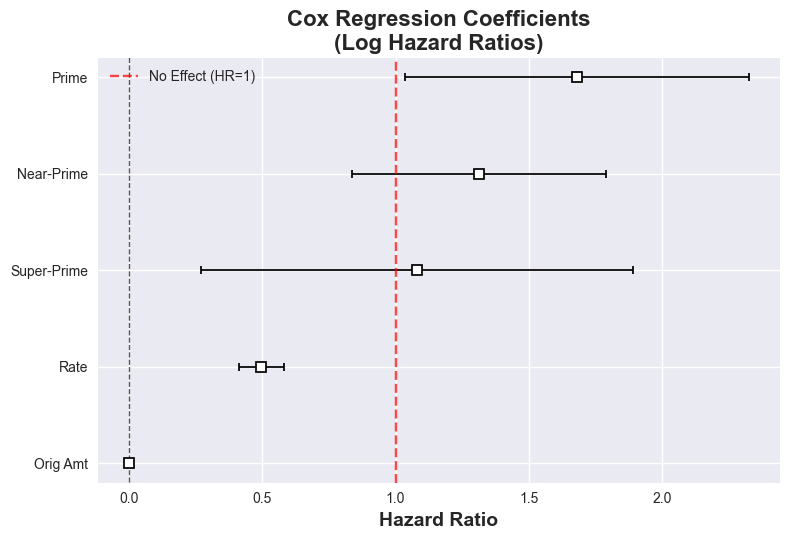

In [55]:
cox_regression_coefficients(cph)

In [56]:
print("Interpretation: Positive coefficients indicate increased risk, negative coefficients indicate decreased risk.")

Interpretation: Positive coefficients indicate increased risk, negative coefficients indicate decreased risk.


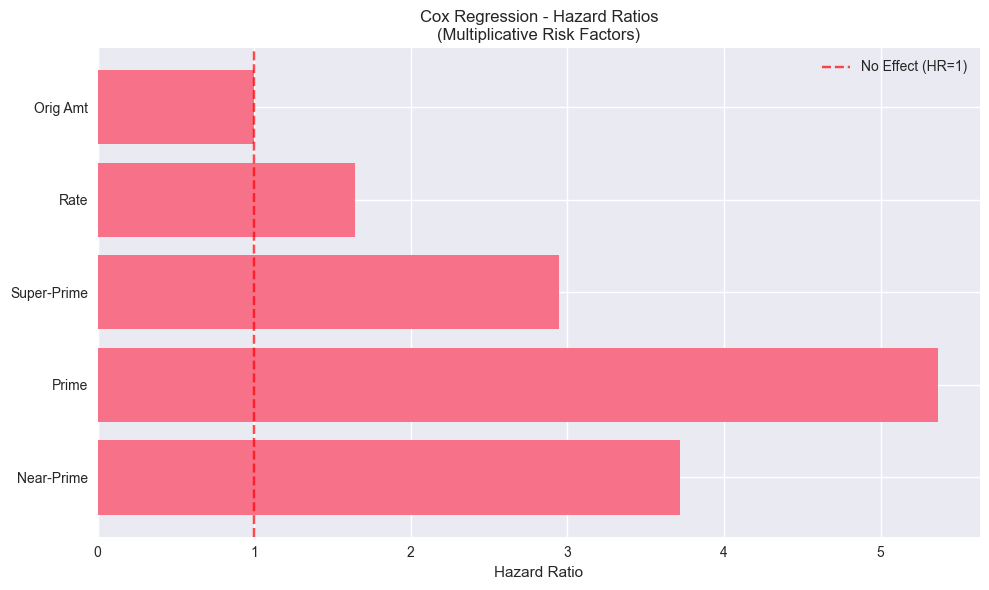

In [68]:
cox_regression_summary(cph)

Discuss the paradox - subprime has highest default probability, but 1.00x hazard ratio due to a timing effect.

## 4.0 Risk Management Applications